# Basic depth map processing

In [1]:
import cv2
from pathlib import Path
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from IPython.display import clear_output
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
import numpy as np
from sklearn.model_selection import train_test_split

def seed_everything(seed=4242):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### Visualization

In [2]:
def depth_to_normals_3d(depth):
    h, w = depth.shape
    depth = depth.astype(np.float32)

    fx = w
    fy = w
    cx = w / 2
    cy = h / 2

    u, v = np.meshgrid(np.arange(w), np.arange(h))

    x = (u - cx) * depth / fx
    y = (v - cy) * depth / fy
    z = depth
    
    points = np.stack((x, y, z), axis=-1)
    dy, dx = np.gradient(points, axis=(0, 1))

    normals = np.cross(dx, dy)

    norm = np.linalg.norm(normals, axis=2, keepdims=True)
    normals /= (norm + 1e-8)

    normals_rgb = ((normals + 1) * 0.5 * 255).astype(np.uint8)
    return normals_rgb

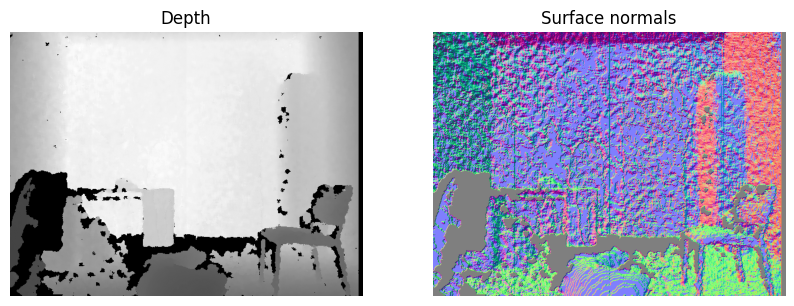

In [3]:
label = 'fall' # fall, adl
sequence_number = random.randint(0, 40 if label == 'adl' else 30) + 1
selected_video = Path(f'../datasets/{label}/sequence-{sequence_number:02}')

frames = sorted(selected_video.glob('*.png'))

for frame_path in frames:
    depth = cv2.imread(str(frame_path), cv2.IMREAD_GRAYSCALE)
    normals = depth_to_normals_3d(depth)

    clear_output(wait=True)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(depth, cmap='gray')
    plt.title('Depth')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(normals)
    plt.title('Surface normals')
    plt.axis('off')

    plt.show()

# Dataset

In [4]:
root = Path('../datasets')
out_root = Path('../data_normals')

if not out_root.exists():
    out_root.mkdir(exist_ok=True)
    for cls in ['adl', 'fall']:
        for seq in (root / cls).iterdir():
            out_seq = out_root / cls / seq.name
            out_seq.mkdir(parents=True, exist_ok=True)

            for f in seq.glob('*.png'):
                depth = cv2.imread(str(f), cv2.IMREAD_GRAYSCALE)
                depth = cv2.resize(depth, (128, 128), interpolation=cv2.INTER_LINEAR)
                normals = depth_to_normals_3d(depth)
                arr = np.array(normals, dtype=np.uint8)

                np.save(out_seq / f'{f.stem}.npy', arr)


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, number_of_frames=180):
        self.samples = []
        self.transform = transform
        self.number_of_frames = number_of_frames

        classes = ['adl', 'fall']
        for label_idx, cls in enumerate(classes):
            cls_path = Path(root_dir) / cls
            for seq_folder in cls_path.iterdir():
                if seq_folder.is_dir():
                    frames = sorted(seq_folder.glob('*.npy'))
                    if len(frames) > 0:
                        self.samples.append((frames, label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        T = len(frame_paths)

        if T >= self.number_of_frames:
            frame_paths = frame_paths[-self.number_of_frames:]
        else:
            pad = self.number_of_frames - T
            frame_paths = [frame_paths[0]] * pad + frame_paths

        imgs = []
        for f in frame_paths:
            arr = np.load(f)              # (H, W, 3), uint8
            img = Image.fromarray(arr)

            if self.transform:
                img = self.transform(img)

            imgs.append(img)

        video_tensor = torch.stack(imgs)  # (T, C, H, W)
        return video_tensor, label


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset = VideoDataset(out_root, transform)

### Model

In [7]:
class CNN_LSTM(nn.Module):
    def __init__(self, hidden_size=256, num_classes=2):
        super(CNN_LSTM, self).__init__()
        
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output: (B, 512, 1, 1)

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.feature_dim = 512
        self.lstm = nn.LSTM(input_size=self.feature_dim, hidden_size=hidden_size, 
                          num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        '''
        x: (B, T, C, H, W)
        B = batch_size
        T = num_frames
        C = channels
        H = height
        W = width
        '''
        B, T, C, H, W = x.size()

        cnn_features = []
        for t in range(T):
            frame = x[:, t, :, :, :]        # (B, C, H, W)
            feat = self.cnn(frame)          # (B, 512, 1, 1)
            feat = feat.view(B, -1)         # (B, 512)
            cnn_features.append(feat)
        

        cnn_features = torch.stack(cnn_features, dim=1) # (B, T, feature_dim)
    
        lstm_out, _ = self.lstm(cnn_features) 
        last_time_step = lstm_out[:, -1, :] # (B, hidden_size)

        out = self.fc(last_time_step) # (B, num_classes)
        return out

In [8]:
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)

summary(model, input_size=(2, 256, 3, 128, 128), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
CNN_LSTM                                      [2, 2]                    --
├─Sequential: 1-1                             [2, 512, 1, 1]            --
│    └─Conv2d: 2-1                            [2, 64, 64, 64]           (9,408)
│    └─BatchNorm2d: 2-2                       [2, 64, 64, 64]           (128)
│    └─ReLU: 2-3                              [2, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                         [2, 64, 32, 32]           --
│    └─Sequential: 2-5                        [2, 64, 32, 32]           --
│    │    └─BasicBlock: 3-1                   [2, 64, 32, 32]           (73,984)
│    │    └─BasicBlock: 3-2                   [2, 64, 32, 32]           (73,984)
│    └─Sequential: 2-6                        [2, 128, 16, 16]          --
│    │    └─BasicBlock: 3-3                   [2, 128, 16, 16]          (230,144)
│    │    └─BasicBlock: 3-4                   [2, 128, 16, 16]      

### Training

In [9]:
num_epochs = 10
batch_size = 4
num_folds = 10

g = torch.Generator()
g.manual_seed(42)
seed_everything(42)

indices = np.arange(len(dataset))
labels = np.array([dataset[i][1] for i in indices])

skf = StratifiedKFold(
    n_splits=num_folds,
    shuffle=True,
    random_state=42
)

checkpoint_dir = Path('../models/surfaces_normals')
checkpoint_dir.mkdir(exist_ok=True, parents=True)



========== FOLD 1/10 ==========
Epoch [1/10] TRAIN Loss: 0.6553 Acc: 55.56% | VAL Loss: 0.5769 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5258 Acc: 79.37% | VAL Loss: 0.4337 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4137 Acc: 93.65% | VAL Loss: 0.3230 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2165 Acc: 98.41% | VAL Loss: 0.1656 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1756 Acc: 96.83% | VAL Loss: 0.0783 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2034 Acc: 93.65% | VAL Loss: 0.1511 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1601 Acc: 90.48% | VAL Loss: 0.1743 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1599 Acc: 95.24% | VAL Loss: 0.2167 Acc: 100.00% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.1502 Acc: 95.24% | VAL Loss: 0.1961 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.1923 Acc: 88.89% | VAL Loss: 0.1087 Acc: 100.00% | LR: 5.00e-05


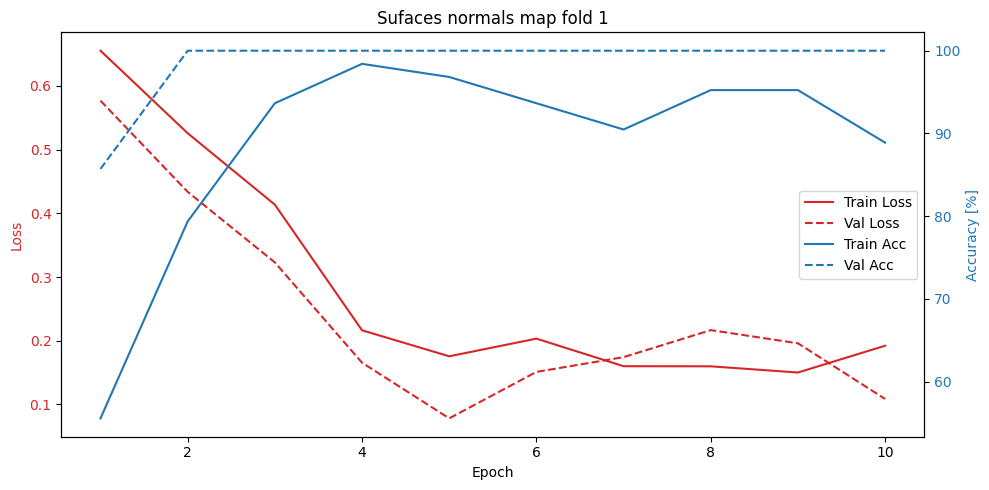


========== FOLD 2/10 ==========
Epoch [1/10] TRAIN Loss: 0.6270 Acc: 69.84% | VAL Loss: 0.5595 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4747 Acc: 93.65% | VAL Loss: 0.4102 Acc: 85.71% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3110 Acc: 96.83% | VAL Loss: 0.2549 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2647 Acc: 88.89% | VAL Loss: 0.2524 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2985 Acc: 87.30% | VAL Loss: 0.1734 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1327 Acc: 100.00% | VAL Loss: 0.1528 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1660 Acc: 93.65% | VAL Loss: 0.1405 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.2020 Acc: 87.30% | VAL Loss: 0.1999 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.2544 Acc: 92.06% | VAL Loss: 0.2288 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.3168 Acc: 84.13% | VAL Loss: 0.1066 Acc: 100.00% | LR: 1.00e-04


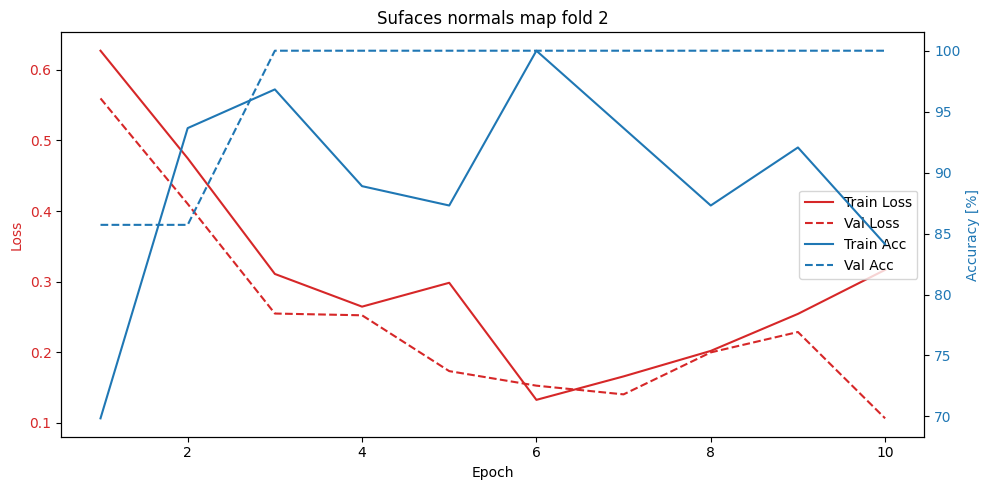


========== FOLD 3/10 ==========
Epoch [1/10] TRAIN Loss: 0.6471 Acc: 55.56% | VAL Loss: 0.5635 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5100 Acc: 80.95% | VAL Loss: 0.4408 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3657 Acc: 92.06% | VAL Loss: 0.3182 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.3831 Acc: 85.71% | VAL Loss: 0.3334 Acc: 85.71% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2485 Acc: 95.24% | VAL Loss: 0.2251 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2982 Acc: 85.71% | VAL Loss: 0.3297 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1515 Acc: 98.41% | VAL Loss: 0.1970 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.3086 Acc: 85.71% | VAL Loss: 0.3472 Acc: 71.43% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1290 Acc: 96.83% | VAL Loss: 0.1083 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1536 Acc: 93.65% | VAL Loss: 0.1851 Acc: 85.71% | LR: 1.00e-04


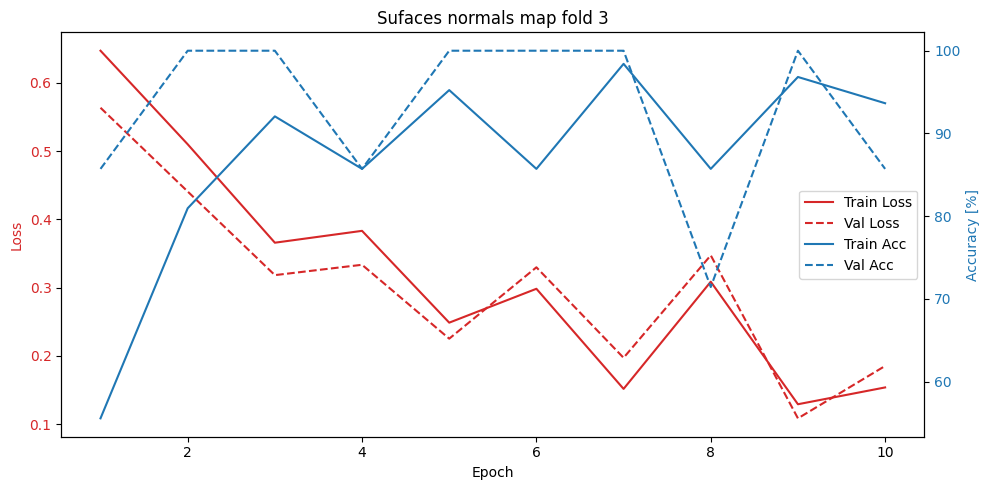


========== FOLD 4/10 ==========
Epoch [1/10] TRAIN Loss: 0.6342 Acc: 73.02% | VAL Loss: 0.6274 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5043 Acc: 85.71% | VAL Loss: 0.5241 Acc: 57.14% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3441 Acc: 90.48% | VAL Loss: 0.3740 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1553 Acc: 100.00% | VAL Loss: 0.0953 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.0895 Acc: 98.41% | VAL Loss: 0.0843 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1455 Acc: 95.24% | VAL Loss: 0.1910 Acc: 85.71% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.0372 Acc: 100.00% | VAL Loss: 0.0741 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0239 Acc: 100.00% | VAL Loss: 0.3672 Acc: 85.71% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.3436 Acc: 87.30% | VAL Loss: 0.0674 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.0783 Acc: 100.00% | VAL Loss: 0.0373 Acc: 100.00% | LR: 1.00e-04


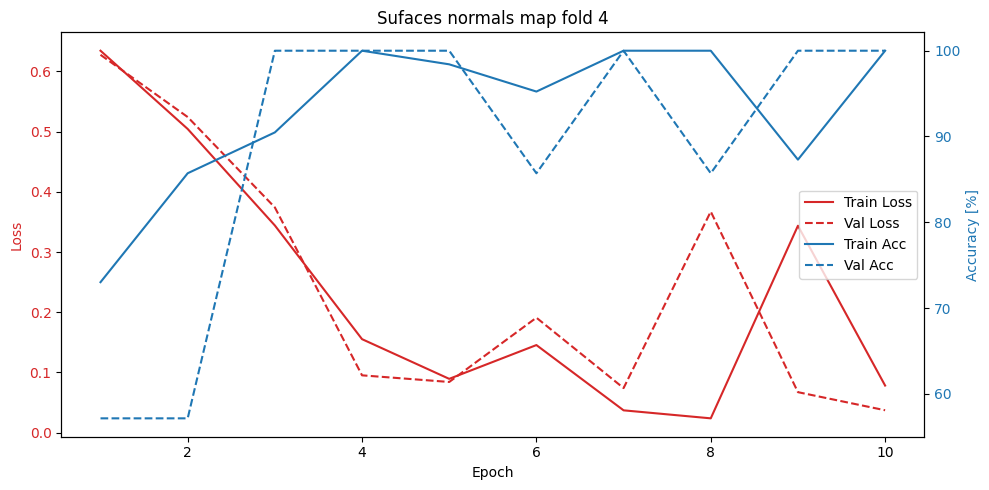


========== FOLD 5/10 ==========
Epoch [1/10] TRAIN Loss: 0.6425 Acc: 61.90% | VAL Loss: 0.6402 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5503 Acc: 82.54% | VAL Loss: 0.5216 Acc: 57.14% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4583 Acc: 79.37% | VAL Loss: 0.4130 Acc: 85.71% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.3600 Acc: 85.71% | VAL Loss: 0.3330 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2126 Acc: 96.83% | VAL Loss: 0.3297 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1604 Acc: 96.83% | VAL Loss: 0.6611 Acc: 57.14% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1840 Acc: 92.06% | VAL Loss: 0.4184 Acc: 71.43% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1245 Acc: 95.24% | VAL Loss: 0.1263 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.2487 Acc: 92.06% | VAL Loss: 0.1086 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1637 Acc: 92.06% | VAL Loss: 0.1239 Acc: 100.00% | LR: 1.00e-04


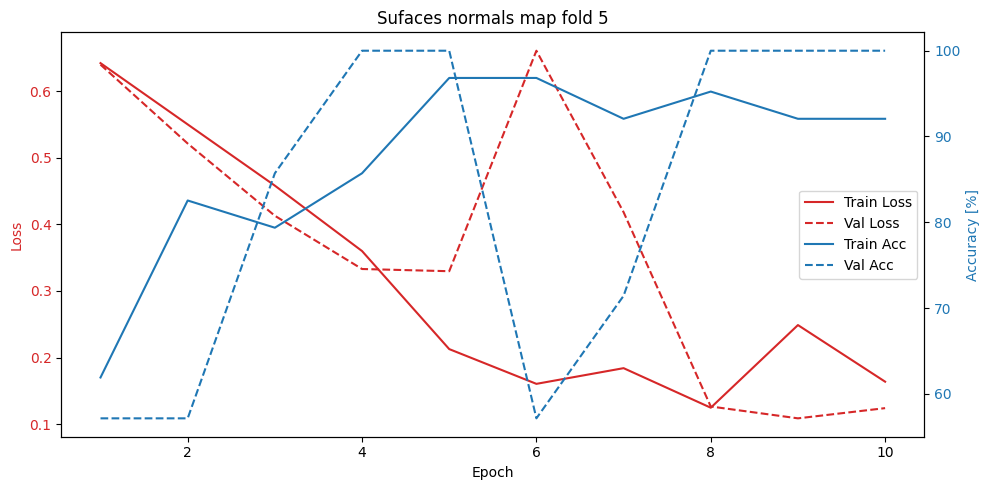


========== FOLD 6/10 ==========
Epoch [1/10] TRAIN Loss: 0.6542 Acc: 50.79% | VAL Loss: 0.5801 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5140 Acc: 79.37% | VAL Loss: 0.4136 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4505 Acc: 82.54% | VAL Loss: 0.3694 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.3343 Acc: 90.48% | VAL Loss: 0.4350 Acc: 71.43% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2718 Acc: 93.65% | VAL Loss: 0.2466 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1840 Acc: 92.06% | VAL Loss: 0.1184 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1459 Acc: 96.83% | VAL Loss: 0.1311 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0806 Acc: 100.00% | VAL Loss: 0.0921 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1614 Acc: 93.65% | VAL Loss: 0.1574 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.3258 Acc: 87.30% | VAL Loss: 0.1446 Acc: 100.00% | LR: 1.00e-04


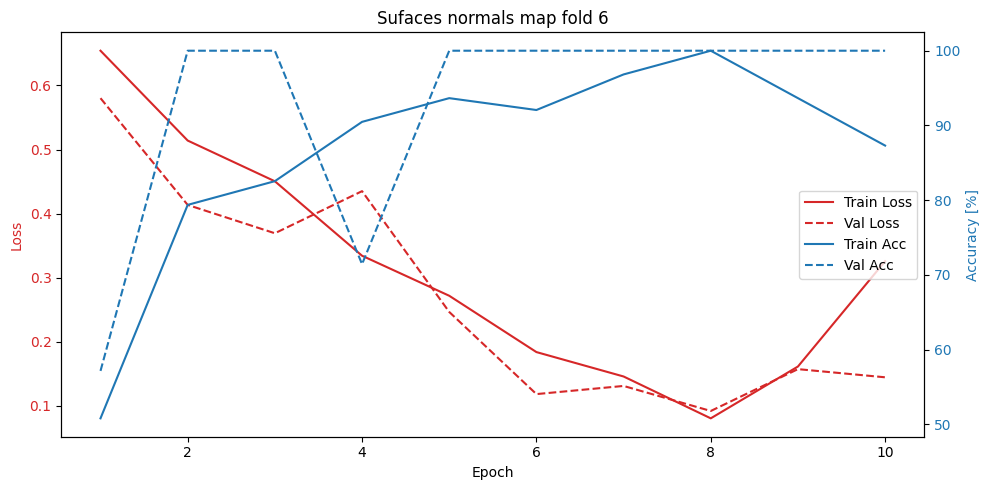


========== FOLD 7/10 ==========
Epoch [1/10] TRAIN Loss: 0.6450 Acc: 57.14% | VAL Loss: 0.5840 Acc: 71.43% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5253 Acc: 82.54% | VAL Loss: 0.5174 Acc: 71.43% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3697 Acc: 90.48% | VAL Loss: 0.3971 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2195 Acc: 96.83% | VAL Loss: 0.2068 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2514 Acc: 90.48% | VAL Loss: 0.4327 Acc: 85.71% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.4054 Acc: 85.71% | VAL Loss: 0.5187 Acc: 85.71% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2220 Acc: 95.24% | VAL Loss: 0.3263 Acc: 71.43% | LR: 5.00e-05
Epoch [8/10] TRAIN Loss: 0.2468 Acc: 90.48% | VAL Loss: 0.4062 Acc: 71.43% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.2290 Acc: 92.06% | VAL Loss: 0.1883 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.1528 Acc: 95.24% | VAL Loss: 0.6359 Acc: 71.43% | LR: 5.00e-05


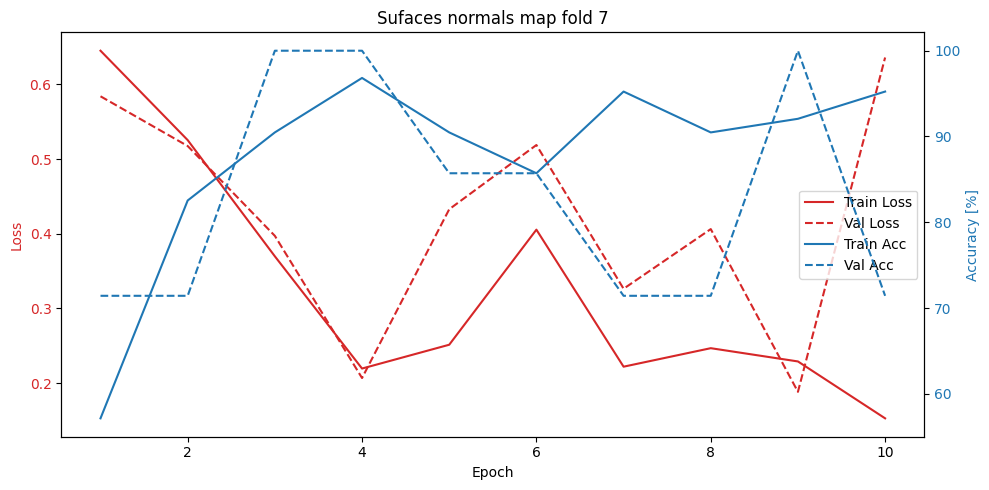


========== FOLD 8/10 ==========
Epoch [1/10] TRAIN Loss: 0.6929 Acc: 58.73% | VAL Loss: 0.6690 Acc: 71.43% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5581 Acc: 71.43% | VAL Loss: 0.5334 Acc: 85.71% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4735 Acc: 84.13% | VAL Loss: 0.4745 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2809 Acc: 92.06% | VAL Loss: 0.2767 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1343 Acc: 98.41% | VAL Loss: 0.3579 Acc: 85.71% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2631 Acc: 90.48% | VAL Loss: 0.2266 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.0963 Acc: 96.83% | VAL Loss: 0.2552 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0313 Acc: 100.00% | VAL Loss: 0.3566 Acc: 85.71% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1371 Acc: 93.65% | VAL Loss: 0.2091 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.0584 Acc: 100.00% | VAL Loss: 0.0974 Acc: 100.00% | LR: 1.00e-04


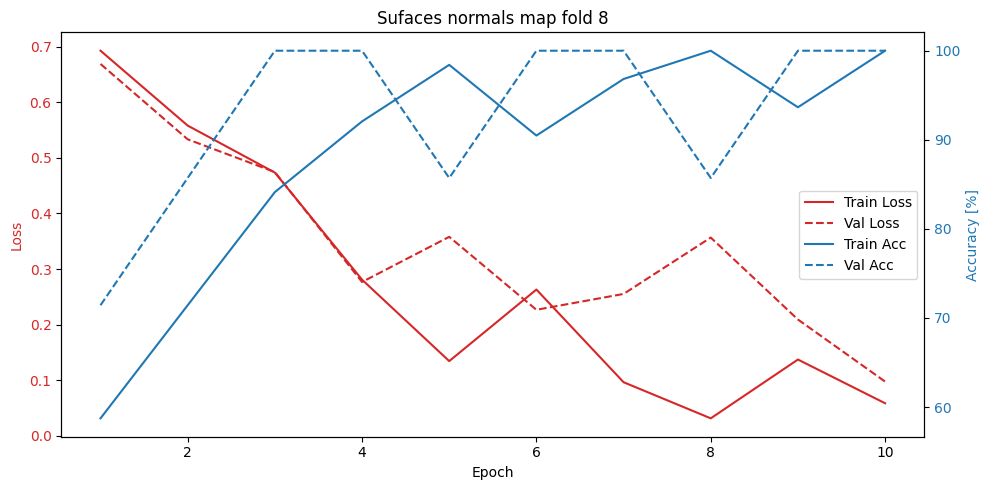


========== FOLD 9/10 ==========
Epoch [1/10] TRAIN Loss: 0.6520 Acc: 57.14% | VAL Loss: 0.5895 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5659 Acc: 79.37% | VAL Loss: 0.5058 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4812 Acc: 87.30% | VAL Loss: 0.3831 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.4203 Acc: 85.71% | VAL Loss: 0.4101 Acc: 85.71% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2618 Acc: 95.24% | VAL Loss: 0.2601 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1194 Acc: 100.00% | VAL Loss: 0.1490 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1106 Acc: 96.83% | VAL Loss: 0.0902 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0905 Acc: 96.83% | VAL Loss: 0.0618 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1407 Acc: 95.24% | VAL Loss: 0.1166 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1597 Acc: 92.06% | VAL Loss: 0.2122 Acc: 100.00% | LR: 1.00e-04


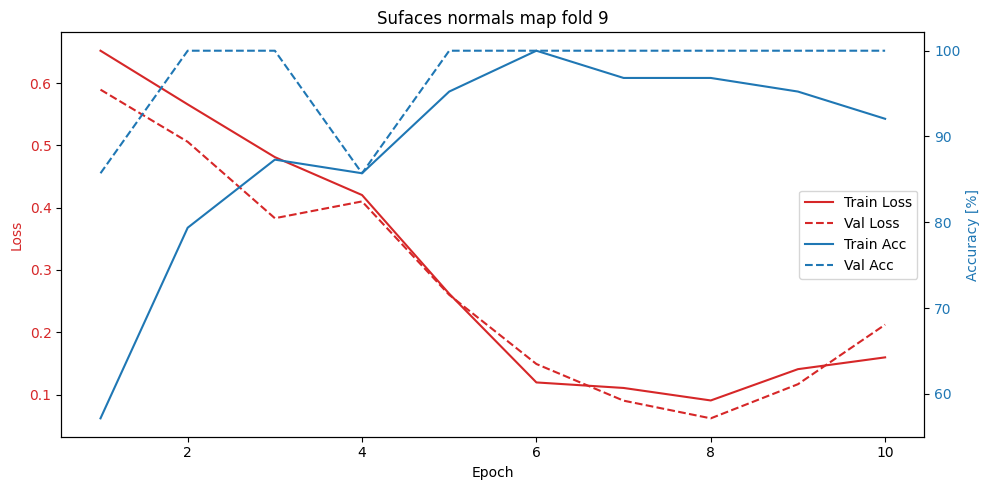


========== FOLD 10/10 ==========
Epoch [1/10] TRAIN Loss: 0.6782 Acc: 49.21% | VAL Loss: 0.6240 Acc: 71.43% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5194 Acc: 85.71% | VAL Loss: 0.4847 Acc: 57.14% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3708 Acc: 90.48% | VAL Loss: 0.2490 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2081 Acc: 98.41% | VAL Loss: 0.1489 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1395 Acc: 93.65% | VAL Loss: 0.1736 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.3064 Acc: 87.30% | VAL Loss: 0.1962 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2749 Acc: 90.48% | VAL Loss: 0.2858 Acc: 85.71% | LR: 5.00e-05
Epoch [8/10] TRAIN Loss: 0.0728 Acc: 100.00% | VAL Loss: 0.0914 Acc: 100.00% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.1445 Acc: 93.65% | VAL Loss: 0.1302 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.1193 Acc: 96.83% | VAL Loss: 0.0923 Acc: 100.00% | LR: 5.00e-05


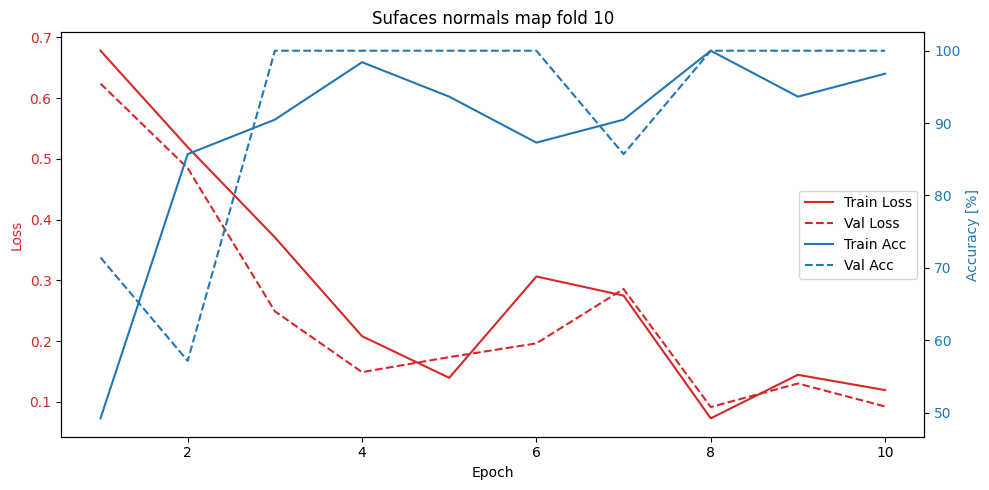

In [10]:
for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels)):
    print(f'\n========== FOLD {fold+1}/{num_folds} ==========')

    model = CNN_LSTM().to(device)
    optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        generator=g
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    best_val_loss = 1e10
    best_model_path = checkpoint_dir / f'best_model_fold_{fold}.pt'

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # ===================== TRAIN =====================
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for videos, y in train_loader:
            videos = videos.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * videos.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss /= len(train_dataset)
        train_acc = 100 * correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ===================== VAL =====================
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for videos, y in val_loader:
                videos = videos.to(device)
                y = y.to(device)

                outputs = model(videos)
                loss = criterion(outputs, y)

                val_loss += loss.item() * videos.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_loss /= len(val_dataset)
        val_acc = 100 * correct / total

        scheduler.step(val_loss)

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        current_lr = optimizer.param_groups[0]['lr']

        print(
            f'Epoch [{epoch+1}/{num_epochs}] '
            f'TRAIN Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | '
            f'VAL Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | '
            f'LR: {current_lr:.2e}'
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    # ===================== PLOT =====================
    epochs = range(1, num_epochs + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_losses, label='Train Loss', color='tab:red')
    ax1.plot(epochs, val_losses, label='Val Loss', color='tab:red', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy [%]', color='tab:blue')
    ax2.plot(epochs, train_accs, label='Train Acc', color='tab:blue')
    ax2.plot(epochs, val_accs, label='Val Acc', color='tab:blue', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    plt.title(f'Sufaces normals map fold {fold+1}')
    plt.tight_layout()
    plt.show()


In [11]:
print('\n========== FINAL EVAL: EACH FOLD MODEL ON FULL DATASET ==========')

final_results = []

full_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    generator=g
)

for fold in range(num_folds):
    model_path = checkpoint_dir / f'best_model_fold_{fold}.pt'
    print(f'\nFold {fold+1}:')

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        error_fragments = []
        for batch_idx, (videos, y) in enumerate(full_loader):
            videos = videos.to(device)
            y = y.to(device)

            outputs = model(videos)
            _, preds = torch.max(outputs, 1)

            incorrect_idx = (preds != y).nonzero(as_tuple=True)[0]

            start_idx = batch_idx * full_loader.batch_size
            global_incorrect_idx = start_idx + incorrect_idx

            for idx in global_incorrect_idx:
                full_path = full_loader.dataset.samples[idx.item()][0]
                full_path_str = str(full_path)
                parts = full_path_str.split('/')[-3:-1]
                fragment = '/'.join(parts)
                error_fragments.append(fragment)


            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    if error_fragments:
        print("Errors:")
        for f in error_fragments:
            print(f)
        
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=['adl', 'fall']
        )

        disp.plot()
        plt.title(f'Surfaces Normals Fold {fold+1}')
        plt.show()

    metrics = {
        'fold': fold,
        'acc': accuracy_score(all_labels, all_preds),
        'prec': precision_score(all_labels, all_preds, average='binary'),
        'rec': recall_score(all_labels, all_preds, average='binary'),
        'f1': f1_score(all_labels, all_preds, average='binary'),
    }

    final_results.append(metrics)
    print(metrics)



========== FINAL EVAL: EACH FOLD MODEL ON FULL DATASET ==========

Fold 1:
{'fold': 0, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 2:
{'fold': 1, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 3:
{'fold': 2, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 4:
{'fold': 3, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 5:
{'fold': 4, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 6:
{'fold': 5, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 7:
{'fold': 6, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 8:
{'fold': 7, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 9:
{'fold': 8, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 10:
{'fold': 9, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}


In [12]:
print('\n========== CV RESULTS ==========')

for metric in final_results[0].keys():
    if metric == 'fold':
        continue
    values = [f[metric] for f in final_results]
    print(
        f'{metric.upper()}: '
        f'{np.mean(values)*100:.2f}% std: {np.std(values)*100:.2f}%'
    )


========== CV RESULTS ==========
ACC: 100.00% std: 0.00%
PREC: 100.00% std: 0.00%
REC: 100.00% std: 0.00%
F1: 100.00% std: 0.00%
